# Semi-Supervised M1 for Presentation
Group: CoronaVAErus

## Setup

### Import libraries

In [1]:
import os
import time
import torch
from functools import reduce
# 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import sklearn

# Torch
import torch
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

### Meta parameters

In [2]:
batch_size = 512
# epochs = 5 # defined at training loop
latent_dim = 8
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NNprint_ = False
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

### Import MNIST Dataset

In [3]:
# transforms arrays into tensors, can be extended
transformations = transforms.Compose([
                          transforms.ToTensor()])
#                           transforms.Lambda(lambda p: Bernoulli(probs=p).sample())])

# define the train and test sets
dset_train = MNIST(root='data', train=True,  transform=transformations, download=True)
dset_test  = MNIST(root='data', train=False, transform=transformations)

def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

### Configure Loaders

In [4]:
def get_target_indexes(dset, classes, n_examples):
  """Get indexes for n_examples of class in classes from dataset

  The returned indexes may be used for subsetting a dataset, e.g.
  if we just want classes 0, 1 and 2 and 10 examples of each.
  """
  idxs = []
  ts = []
  n_samples = n_examples * len(classes)

  for j, x in enumerate(dset.targets):
    if (ts.count(x.numpy()) < n_examples) and (x.numpy() in classes):
      ts.append(x.numpy())
      idxs.append(j)

    if len(idxs) == n_samples:
      break

  return idxs

In [5]:
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets,classes))
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets,classes))

# subset training data
idx_train_subset = get_target_indexes(dset_train, classes, 100)
dset_train_subset = torch.utils.data.Subset(dset_train, idx_train_subset)

dset_train_subset_loader = torch.utils.data.DataLoader(
  dset_train_subset,
  batch_size=batch_size)

# subset test data
idx_test_subset = get_target_indexes(dset_test, classes, 100)
dset_test_subset = torch.utils.data.Subset(dset_test, idx_test_subset)

dset_test_subset_loader = torch.utils.data.DataLoader(
  dset_test_subset,
  batch_size=batch_size)

### Plot examples

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            if sample:
                data = model.sample()
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, interpolation='none')
        else:
            plt.imshow(data[i][0], interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

In [7]:
# plot_examples() # binarized from dataset

### Torch auxiliary modules

In [8]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

## M1 - convolutional VAE

In [9]:
class M1(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
        super(M1, self).__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            torch.nn.LeakyReLU(),
            Flatten()
        )

        self.mu = torch.nn.Linear(h_dim, z_dim)
        self.logsigma = torch.nn.Linear(h_dim, z_dim)
        self.upscale_z = torch.nn.Linear(z_dim, h_dim)

        self.decoder = torch.nn.Sequential(
            UnFlatten(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(
                64, 32, kernel_size=4, padding=0, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(
                32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * eps.to(device)
        return z

    def encode(self, x):
        # pass x through conv encoder and flatten output to obtain h
        h = self.encoder(x)
        # use relu to prevent negative values
        mu, logvar = self.mu(h), self.logsigma(h)
        return mu, logvar

    def decode(self, z):
        h = self.upscale_z(z)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x):
        # encode x to mu and logvar
        mu, logvar = self.encode(x)

        # sample z using mu and logvar
        z = self.reparameterize(mu, logvar)

        # decode z to get reconstruction
        x_recon = self.decode(z)

        return mu, logvar, z, x_recon

    def elbo(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.to(
            device), size_average=False, reduction='sum')

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        # TODO: is this mean or sum?
        KLD = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE - KLD, BCE, KLD

    def sample(self, batch_size: int = 100,z_out=False):
        """Sample z~p(z) and return p(x|z) / reconstruction
        """
        # sample z ~ N(0,I)
        mu, logvar = torch.zeros((batch_size, self.z_dim)), torch.ones(
            batch_size, self.z_dim)
        z = self.reparameterize(mu, logvar)
        if z_out:
            return z
        # decode sampled z with condition
        else:
            x_recon = self.decode(z)
            return x_recon.detach()  # no gradient_fn

# test model
model = M1(z_dim=latent_dim).to(device)
# print("Model\n", model)

# test forward-pass
mu, logvar, z, x_recon = model(example_data.to(device))
# print(example_data.shape, mu.shape, logvar.shape, z.shape, x_recon.shape)

# test elbo
loss, bce, kld = model.elbo(x_recon, example_data, mu, logvar)

# test sampling
sample_recon = model.sample()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Training functions

In [10]:
def fit_model(model, train_loader):
    model.train()
    running_loss = 0.0
    # Run each batch in training dataset
    for idx, (images, labels) in enumerate(train_loader):
        mu, logvar, z, recon_images = model(images.to(device))
        
        loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss
    
    loss_mean = running_loss/len(train_loader.dataset)
    return loss_mean
    

def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            mu, logvar, z, recon_images = model(images.to(device))
            loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
            running_loss += loss

    return running_loss/len(test_loader.dataset)

# 2.3  Semi-Supervised VAE (M1)

We have now trained a VAE on the full unlabeled dataset.  We will now implement the M1 model from Semi-Supervised Learning with Deep Generative Models. This amounts to simply traininga classifier on top of the representations learned by our VAE.

1. Extract 100 labeled datapoints from MNIST (10 from each class).
2.(Report) Train a classifier on their latent representation.  First try a linear classifier and then experiment with other types of classifiers.  Report the accuracies.
3.(Report) Implement  some  simple  baselines:  Train  a  linear  classifier  or  neural  network  from scratch using only the 100 labeled data points.  Report the accuracies.

In [11]:
# 0 Train VAE on all available data (X), without labels (y)
model = M1(image_channels=1, h_dim=1024, z_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
epochs = 10
learning_rate = 1e-3

train_loss = []
test_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    print("\t Training ...")
    train_epoch_loss = fit_model(model, train_loader)
    
    print("\t Testing ...")
    test_epoch_loss = test_model(model, test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)

    print(f"Train ELBO: {train_epoch_loss:.4f}")
    print(f"Val ELBO: {test_epoch_loss:.4f}")

# torch.save(model.state_dict(), 'presentation_m1.torch')

Epoch 1 of 10
	 Training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


	 Testing ...
Train ELBO: 211.1174
Val ELBO: 170.5913
Epoch 2 of 10
	 Training ...
	 Testing ...
Train ELBO: 132.7293
Val ELBO: 120.2859
Epoch 3 of 10
	 Training ...
	 Testing ...
Train ELBO: 116.1232
Val ELBO: 114.2486
Epoch 4 of 10
	 Training ...
	 Testing ...
Train ELBO: 111.8610
Val ELBO: 110.5278
Epoch 5 of 10
	 Training ...
	 Testing ...
Train ELBO: 109.2934
Val ELBO: 109.4811
Epoch 6 of 10
	 Training ...
	 Testing ...
Train ELBO: 107.7591
Val ELBO: 108.4531
Epoch 7 of 10
	 Training ...
	 Testing ...
Train ELBO: 106.6626
Val ELBO: 106.2247
Epoch 8 of 10
	 Training ...
	 Testing ...
Train ELBO: 105.6797
Val ELBO: 106.5178
Epoch 9 of 10
	 Training ...
	 Testing ...
Train ELBO: 104.9365
Val ELBO: 105.2817
Epoch 10 of 10
	 Training ...
	 Testing ...
Train ELBO: 104.4611
Val ELBO: 105.0967


(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'ELBO'))

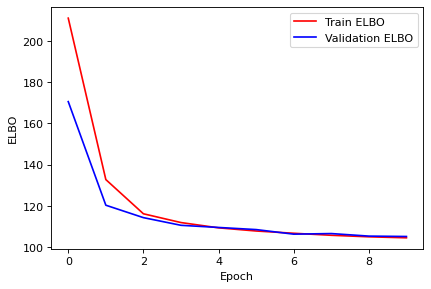

In [13]:
x_epoch = np.arange(len(train_loss))
plt.figure(dpi=80, facecolor='w', edgecolor='k')
plt.plot(x_epoch, train_loss, 'r', x_epoch, test_loss, 'b')
plt.legend(['Train ELBO', 'Validation ELBO'])
plt.xlabel('Epoch'), plt.ylabel('ELBO')

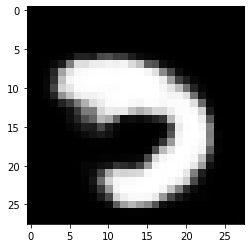

In [14]:
# plot single reconstructions
x_recon = model.sample(1)
plt.imshow(x_recon[0][0].cpu(), cmap='gray', interpolation='none')

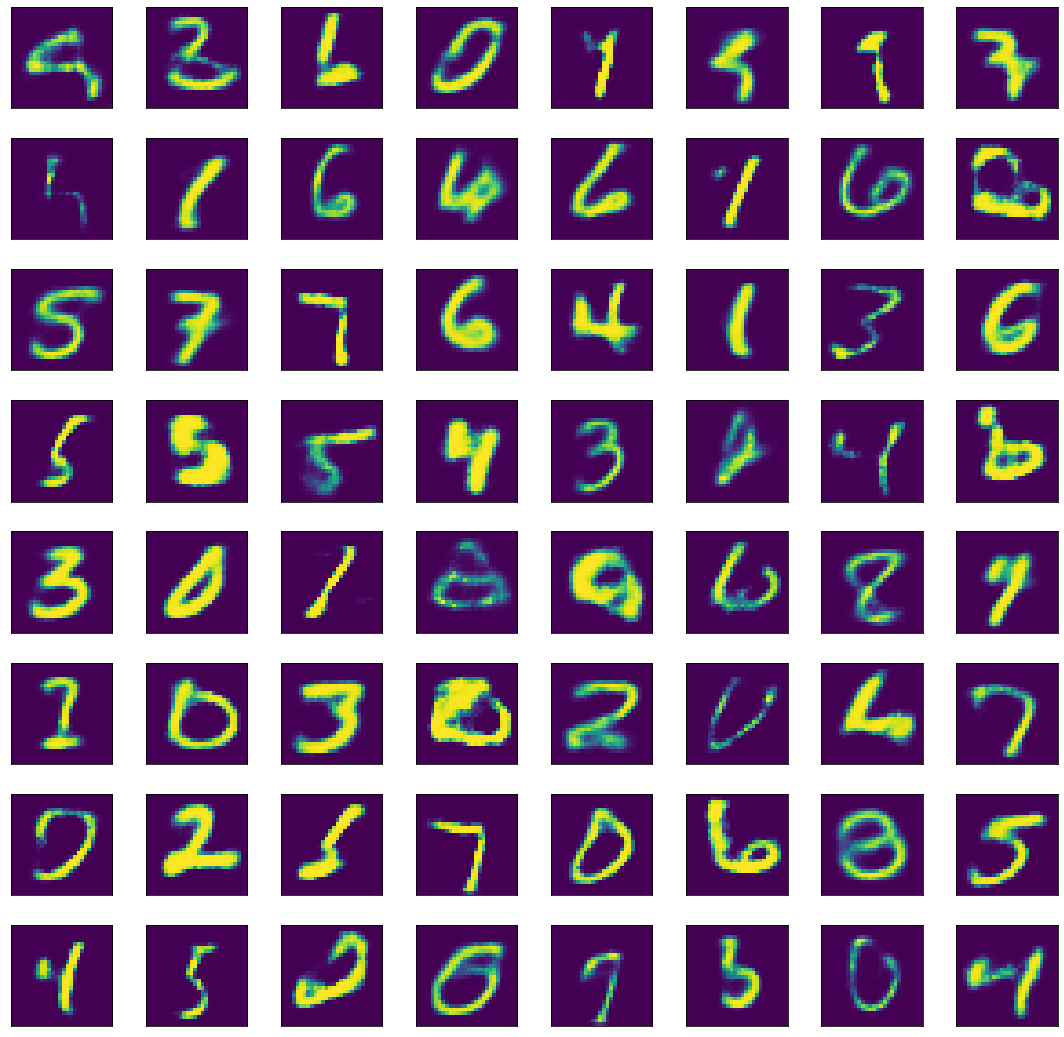

In [15]:
# plot 8x8 reconstructions
plot_examples(model=model, sample=True)

# Train Classifier on top of M1

In [16]:
z_in=model.sample(batch_size=10000,z_out=True)

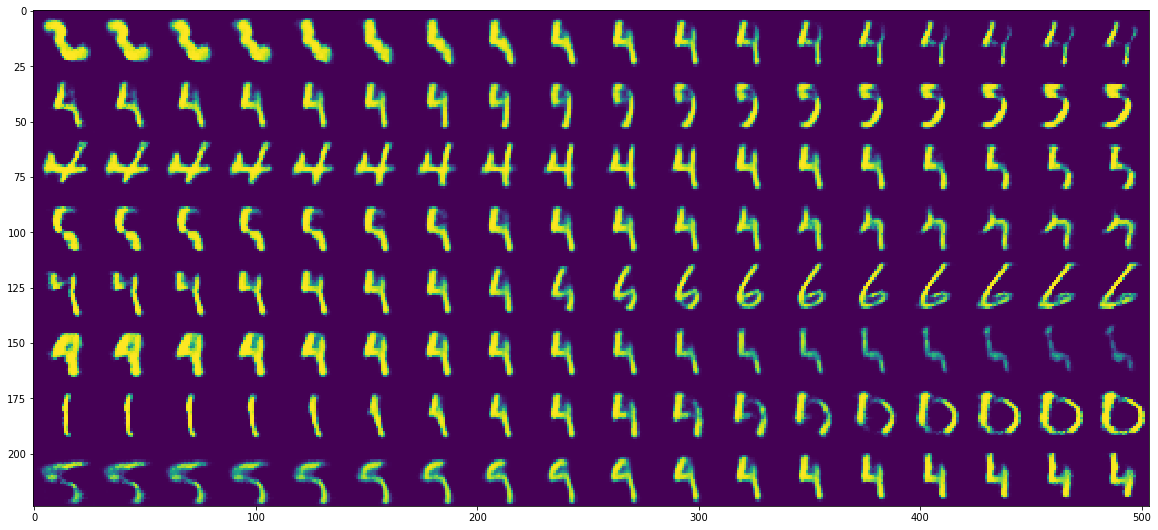

In [25]:
def plot_interpolation(z_in=None,image_n=0,latent_dim=latent_dim,imsize=28,interpolate_dim=20,std_=3,batch_size=100):
  if z_in is None:
      ztest =model.sample(batch_size=batch_size,z_out=True)
  else:
    ztest=z_in
  test_data=torch.zeros(latent_dim*interpolate_dim,latent_dim)
  for i in range(test_data.shape[0]):
      test_data[i]=ztest[image_n]

  range_=np.zeros([latent_dim,interpolate_dim])
  for c,i in enumerate(ztest.std(0).cpu().detach().numpy()):
      range_[c]=np.linspace(-std_*i,std_*i,int(interpolate_dim))
      
  for c in range(latent_dim*interpolate_dim):
      test_data[c][int(c/interpolate_dim)]=range_[int(c/interpolate_dim)][c%interpolate_dim]
      # print(c,int(c/interpolate_dim),"_",int(c/interpolate_dim),c%interpolate_dim,"_",range_[int(c/interpolate_dim)][c%interpolate_dim])
      # print(c,test_data[c].cpu().detach().numpy())
  smple_pic =model.decode(test_data.to(device))


  all_pics=np.zeros([imsize*latent_dim,imsize*interpolate_dim])
  for i in range(latent_dim):
      for j in range(interpolate_dim):
  #         print(i,j)
          all_pics[i*imsize:(i+1)*imsize,j*imsize:(j+1)*imsize]=smple_pic[(interpolate_dim*i)+j][0].cpu().data
  fig = plt.figure()
  fig.set_figheight(40)
  fig.set_figwidth(20)
  plt.imshow(all_pics, interpolation='none')
  return(ztest.std(0).cpu().detach().numpy())
std__=plot_interpolation(z_in=z_in,image_n=0,latent_dim=latent_dim,imsize=28,interpolate_dim=18,std_=3,batch_size=10000)

In [18]:
std__

array([1.6414384, 1.6422763, 1.6448314, 1.6386235, 1.6376548, 1.66226  ,
       1.6511979, 1.6475519], dtype=float32)

In [19]:
# 2 (Report) Train a classifier on their latent representation. 
# First try a linear classifier and then experiment with other types of classifiers. Report the accuracies.

from sklearn.linear_model import LogisticRegression


idx_train_subset = get_target_indexes(dset_train, classes, 10)
X_train = dset_train.data[idx_train_subset].type(torch.float)
X_train = torch.unsqueeze(X_train, 1)
y_train = dset_train.targets[idx_train_subset].numpy()

model.eval()
with torch.no_grad():
    mu, logvar, z, x_recon = model(X_train.to(device))
    Z_train = z.cpu().numpy()


clf = LogisticRegression(random_state=0).fit(Z_train, y_train)
y_pred = clf.predict(Z_train)
train_acc = sklearn.metrics.accuracy_score(y_train, y_pred)
print("Mean acc (train): ", train_acc)


Mean acc (train):  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Mean acc (test):  0.74


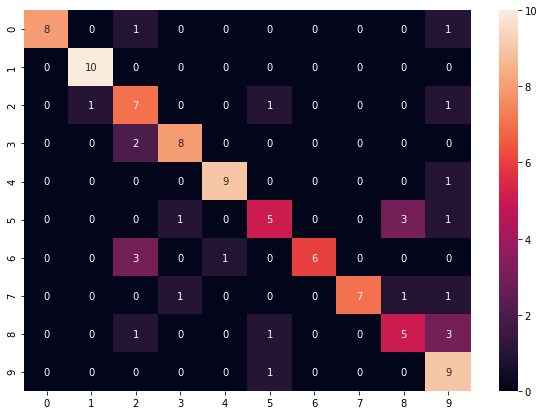

In [20]:
idx_test_subset = get_target_indexes(dset_test, classes, 10)
X_test = dset_test.data[idx_test_subset].type(torch.float)
X_test = torch.unsqueeze(X_test, 1)
y_test = dset_test.targets[idx_test_subset].numpy()

model.eval()
with torch.no_grad():
    mu, logvar, z, x_recon = model(X_test.to(device))
    Z_test = z.cpu().numpy()


# TODO: proper test
y_pred = clf.predict(Z_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_pred)
print("Mean acc (test): ", test_acc)

cm = sklearn.metrics.confusion_matrix(y_true = y_test, y_pred = y_pred)
df_cm = pd.DataFrame(cm, index = [str(i) for i in classes],
                       columns = [str(i) for i in classes])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [21]:
# # This snippet is for training the simple classifier with more data

X_test = None
err = []
with torch.no_grad():
    for idx, (images, labels) in enumerate(dset_test_subset_loader):
        recon_images, mu, logvar = model(images.to(device), None)
        X_test = mu.numpy()
        y_test = labels.numpy()
        err.append(clf.score(X_test, y_test))

print("Mean loss (test): ", np.mean(np.array(err)))

TypeError: ignored